# Code for generating Figure 3

## "Increasing the number of switches inefficiently improves performance"

This Python notebook contains code for generating the third figure from the paper "Storing long-lived memories via molecular error correction: a minimal mathematical model of Crick's memory switch".

In [696]:
%load_ext autoreload
%autoreload 2

# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binom

from functions.solutions import get_probs_twostate, get_probs_twotwostate, get_probs_ntwostate
from functions.solutions import get_eigenvectors_twotwostate, get_mean_var_ntwostate
from functions.MI import get_MI, get_capacity, get_t_life
from functions.gillespie import simulate_ssa
from functions.plotting import plot_colorbar, plot_eigenvector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [722]:
# aesthetics
lw = 4
c_red = (1,0,0)
c_green = np.array([57,181,74])/255
c_lightblue = np.array([187,214,255])/255
sim_colors = ['chocolate', 'fuchsia', 'deepskyblue', 'gold'] 

c_eps_low = 'palevioletred'
c_eps_med = 'hotpink'
c_eps_hi = 'pink'

# ----------

# saving-related utility function
results_folder = 'results/fig3/'
format_list = ['.png', '.svg', '.pdf']

def save_file(name):
    for end in format_list:
        plt.savefig(results_folder+name+end, bbox_inches='tight', transparent=True)
    return

<center>
<img src="fig_images/fig3-twotwo.png" width="1000"/></center>

**Caption.** (a) Schematic of the pair model and three example stochastic simulations ($\gamma = 1, \epsilon = 0.1$). (b) First and second right eigenvectors of the pair model's Hamiltonian, which indicate how probability flows through the system. Blue: probability inflow, red: probability outflow. (c) State occupancy probabilities over time for the pair model ($\gamma = 1, \epsilon = 0.1$). Shaded region: time before $\tau = 1/(\epsilon + \gamma)$. (d) Mutual information vs time for the two-state (black) and pair model (blue) ($\gamma = 1, \epsilon = 0.01$). Dots and dashed lines indicate lifetimes. (e) Lifetime vs $\log_{10} \epsilon$ for two-state and pair model ($\gamma = 1$). (f) Capacity vs $\epsilon$ for two-state and pair model ($\gamma = 1$). (g) Schematic of the multi-switch model and three example stochastic simulations ($N = 10, \gamma = 1, \epsilon = 0.1$). (h) Time scales $\tau_i = - 1/\lambda_i$ of the multi-switch model for $N = 2$ and $N = 10$. Note that, as $N$ increases, only faster time scales are added. (i) Mean fraction of switches that are marked over time ($N = 10, \gamma = 1, \epsilon = 0.01$). Shaded region: $\pm 1$ standard deviation. (j) Mutual information vs time for the multi-switch model for different values of $N$ ($\gamma = 1, \epsilon = 0.01$). (k) Lifetime vs $\log_{10} N$ for different values of the ambient marking rate $\epsilon$ ($\gamma = 1$). (l) Capacity vs $\epsilon$ for different values of $N$ ($\gamma = 1$).

## a. Gillespie simulations, pair model

Simulate the pair model using the Gillespie algorithm. This amounts to simulating the two-state model with $N = 2$ molecules.

In [707]:
# propensity function of two-state model (and pair model)
def prop_twostate(state, params):
    eps, gamma = params['eps'], params['gamma']
    # state: (num_samples, D)
    return np.array( [ eps*(1 - state[:,0]), gamma*state[:,0] ]).T

# set up propensity function and stoichiometry vector
params = {'eps':0.1, 'gamma':1}
prop = lambda state: prop_twostate(state, params)
stoich = np.array([[1],[-1]])

In [709]:
num_samples = 3; x0 = 2*np.ones((num_samples, 1))
num_steps = 10

np.random.seed(1)   # use 1; 84 is good
t_rec, counts = simulate_ssa(x0, prop, stoich, num_steps)

arg = np.flip(np.argsort(t_rec[1,:]))

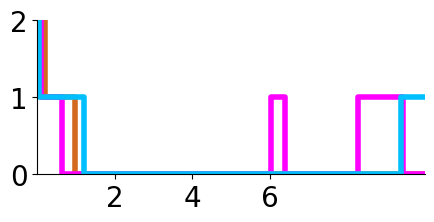

In [713]:
fig, ax = plt.subplots(figsize=(5,2))


for j in range(num_samples):
    ind = arg[j]  
    plt.plot(t_rec[:,ind], counts[:,ind,0], drawstyle='steps-post', linewidth=lw, color=sim_colors[j])


ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0, 10); plt.ylim(0, 1)    
plt.xticks([2, 4, 6],fontsize=20); plt.yticks([0, 1, 2],  fontsize=20)

save_file('gillespie_twotwostate')
plt.show()

### b. Visualize eigenvectors of pair model

Visualize eigenvectors of the pair model ($\boldsymbol{v}_1$ and $\boldsymbol{v}_2$). In our visualization, blue means probability inflow and red means probability outflow.

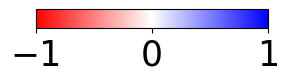

In [717]:
# Plot colorbar
name = 'colorbar'
plot_colorbar(name, save_file)

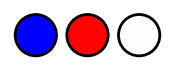

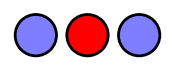

In [719]:
# Get eigenvectors of pair model
eps, gamma = 0.01, 1; params = {'eps':eps, 'gamma':gamma}
eigenvectors = get_eigenvectors_twotwostate(params)
v1 = eigenvectors['v1']; v2 = eigenvectors['v2']

# Visualize eigenvectors
plot_eigenvector('eigenvector_twotwostate_v1', v1, save_file)
plot_eigenvector('eigenvector_twotwostate_v2', v2, save_file)

## c. State occupancy probabilities, pair model

Plot state occupancy probabilities $p_0(t)$ (unmarked probability), $p_1(t)$ (partially marked probability), and $p_2(t)$ (fully marked probability) over time for the pair model.

In [725]:
t_min, t_max, num_t = 0, 5, 200
t = np.linspace(t_min, t_max, num_t)

eps, gamma = 0.1, 1; params = {'eps':eps, 'gamma':gamma}
_, p_t = get_probs_twotwostate(t, params)
p_minus, p_mid, p_plus = p_t.T

tau = 1/(eps + gamma)      # slowest time scale, - 1/lamb_1

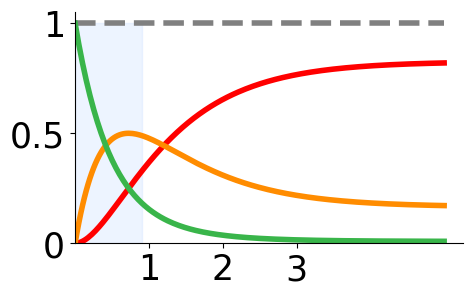

In [727]:
fig, ax = plt.subplots(figsize=(5,3))

plt.fill_between(np.array([0,tau]), np.array([1,1]), alpha=0.25, color=c_lightblue) 
plt.plot(t, np.ones_like(t), color='gray', linestyle='--', linewidth=lw)

plt.plot(t, p_minus, linewidth=lw, color=c_red)
plt.plot(t, p_mid, linewidth=lw, color='darkorange')
plt.plot(t, p_plus, linewidth=lw, color=c_green)

ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0,None); plt.ylim(0, 1.05)
plt.xticks([1, 2, 3],fontsize=25)
plt.yticks([0,0.5, 1], ['0','0.5', '1'], fontsize=25)

name = 'state_occ_twotwo'
save_file(name)
plt.show()

## d. Mutual information vs time for pair model

Mutual information vs time for the pair model (blue) and two-state model (black). The most important thing to notice is that the pair model's mutual information curve is always higher.

In [730]:
t_min, t_max, num_t = 0, 3., 5000
t = np.linspace(t_min, t_max, num_t)

eps, gamma = 0.01, 1; params = {'eps':eps, 'gamma':gamma}
p_z_given_0, p_z_given_1 = get_probs_twotwostate(t, params)
MI = get_MI(p_z_given_0, p_z_given_1)

p_og_0, p_og_1 = get_probs_twostate(t, params)
MI_og = get_MI(p_og_0, p_og_1)


t_life = t[np.argwhere(MI <= 0.5*MI[0])[0]]
t_life_og = t[np.argwhere(MI_og <= 0.5*MI_og[0])[0]]

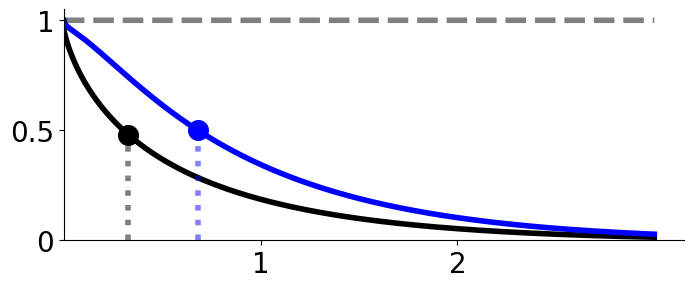

In [733]:
fig, ax = plt.subplots(figsize=(8,3))


plt.plot(t, MI_og, color='black', linewidth=lw)
plt.plot(t, MI, color='blue', linewidth=lw)


plt.scatter(t_life, 0.5*MI[0], color='blue', s=200, zorder=3)
plt.plot( t_life*np.ones(10), np.linspace(0, 0.5*MI[0], 10), linestyle='dotted', color='blue', linewidth=4, alpha=0.5,zorder=3)

plt.scatter(t_life_og, 0.5*MI_og[0], color='black', s=200, zorder=3)
plt.plot( t_life_og*np.ones(10), np.linspace(0, 0.5*MI_og[0], 10), linestyle='dotted', color='black', linewidth=4, alpha=0.5,zorder=3)

plt.plot(t, np.ones_like(t), linestyle='--', color='black', linewidth=4, alpha=0.5) 

ax.spines[['right', 'top']].set_visible(False)
plt.xticks([0, 1, 2, 3],fontsize=20); 
plt.xticks([1, 2],fontsize=20); 
plt.yticks([0,0.5, 1], ['0','0.5', '1'], fontsize=20)
plt.xlim(0., None); plt.ylim(0, None)

save_file('MI_twotwo_vs_two')
plt.show()

## e. Lifetime vs marking noise for the pair model

Plot lifetime vs marking noise for the pair model (blue) and two-state model (black).

In [746]:
t_min, t_max, num_t = 0, 5, 10000
t = np.linspace(t_min, t_max, num_t)

num_eps = 100; eps_list = np.logspace(-3, 0, num_eps)
gamma = 1

params_list = []
for i in range(num_eps): params_list.append( {'eps':eps_list[i], 'gamma':gamma}   )
t_life = get_t_life(t, params_list, get_probs_twotwostate, get_MI )
t_life_og = get_t_life(t, params_list, get_probs_twostate, get_MI )

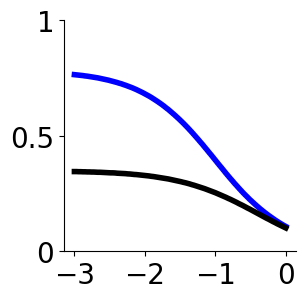

In [748]:
fig, ax = plt.subplots(figsize=(3,3))

plt.plot(np.log10(eps_list), t_life, color='blue', linewidth=lw)
plt.plot(np.log10(eps_list), t_life_og, color='black', linewidth=lw)


plt.ylim(0, 1.)
plt.xticks(fontsize=20); 
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'],fontsize=20); 
ax.spines[['right', 'top']].set_visible(False)
save_file('lifetime_twotwostate')
plt.show()

## f. Capacity vs marking noise for the pair model

Plot capacity vs marking noise for the pair model (blue) and two-state model (black).

In [752]:
# p = p(1 | 0), false positive
gamma = 1
eps_min, eps_max, num_eps = 0, gamma, 200
epsilon = np.linspace(eps_min, eps_max, num_eps)

p_base = epsilon/(gamma + epsilon) + 1e-15
p = p_base**2    # because of binomial structure, can get false-positive prob for pair model by squaring two-state false-positive prob

# Get capacities
C = get_capacity(p)
C_old = get_capacity(p_base)

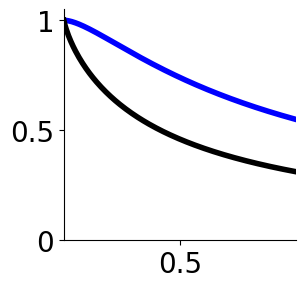

In [754]:
fig, ax = plt.subplots(figsize=(3,3))

plt.plot(epsilon, C, color='blue', linewidth=lw)
plt.plot(epsilon, C_old, color='black', linewidth=lw)

plt.xlim(0, 1); plt.ylim(0, 1.05)
plt.xticks([0.5],fontsize=20); 
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'],fontsize=20); 
ax.spines[['right', 'top']].set_visible(False)

save_file('capacity_twotwostate')
plt.show()

## g. Gillespie simulations, $N$ two-state models

Simulate $N$ two-state models using the Gillespie algorithm. This amounts to simulating the two-state model with $N$ molecules.

In [759]:
# Set up propensity function and stoichiometry vector
eps, gamma = 0.1, 1; params = {'eps':eps, 'gamma':gamma}
prop = lambda state: prop_twostate(state, params)
stoich = np.array([[1],[-1]])


N = 10
num_samples = 3; x0 = N*np.ones((num_samples, 1))
num_steps = 10

# Simulate
np.random.seed(5)   
t_rec, counts = simulate_ssa(x0, prop, stoich, num_steps)

arg = np.flip(np.argsort(t_rec[1,:]))

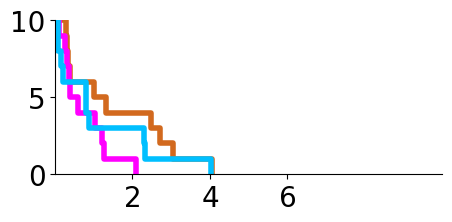

In [763]:
fig, ax = plt.subplots(figsize=(5,2))

for j in range(num_samples):
    ind = arg[j]    
    plt.plot(t_rec[:,ind], counts[:,ind,0], drawstyle='steps-post', linewidth=lw, color=sim_colors[j])

ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0, 10); plt.ylim(0, 1)    
plt.xticks([2, 4, 6],fontsize=20); plt.yticks([0, 5, 10],  fontsize=20)

name = 'gillespie_Nstate'
save_file(name)
plt.show()

## h. Eigenvalue / time scale ladder, $N$ two-state models

Visualize eigenvalues (and the associated time scales, $\tau_i = - 1/\lambda_i$) of $N$ two-state models as a ladder. Since the $k$-th eigenvalue is $\lambda_k = - k (\epsilon + \gamma)$, the $k$-th time scale is $\tau_k = \frac{1}{k (\epsilon + \gamma)}$. This means that adding additional molecules only adds faster (rather than slower) time scales.

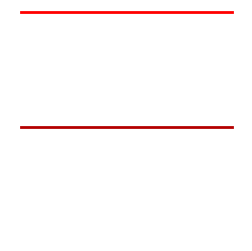

In [770]:
fig, ax = plt.subplots(figsize=(3,3))

for N in range(1, 2+1):
    plt.plot([0, 1], [1/N, 1/N], color = ((1/np.sqrt(N)), 0, 0), linewidth=2)

ax.spines[['right', 'top']].set_visible(False)
plt.ylim(0, 1.01)
ax.axis('off')

save_file('eigenvalue_ladder_2')
plt.show()

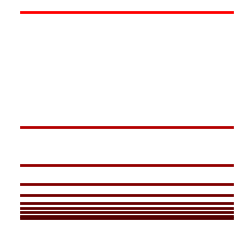

In [772]:
fig, ax = plt.subplots(figsize=(3,3))

for N in range(1, 10+1):
    plt.plot([0, 1], [1/N, 1/N],color = ((1/np.sqrt(N)), 0, 0), linewidth=2)

ax.spines[['right', 'top']].set_visible(False)
plt.ylim(0, 1.01)
ax.axis('off')

save_file('eigenvalue_ladder_10')
plt.show()

## i. Expected marked fraction over time, $N$ two-state models

Plot average marked fraction (number of marked molecules divided by the total number of molecules $N$) over time for $N$ two-state molecules. $N = 10$ depicted. As $N$ increases, the model dynamics concentrate around this mean trajectory.

In [784]:
t_min, t_max, num_t = 0, 5, 200
t = np.linspace(t_min, t_max, num_t)

eps, gamma = 0.01, 1; 
N = 10
params = {'eps':eps, 'gamma':gamma, 'N':N}

x, sigma = get_mean_var_ntwostate(t, params)

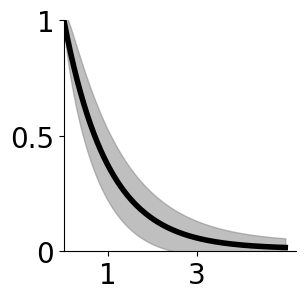

In [786]:
fig, ax = plt.subplots(figsize=(3,3))


plt.plot(t, x, linewidth=lw,zorder=3, color='black')
plt.fill_between(t, x-sigma, x+sigma, alpha=0.5, color='gray')

ax.spines[['right', 'top']].set_visible(False)
plt.xticks([1, 3],fontsize=20)
plt.yticks([0, 0.5, 1],['0','0.5','1'], fontsize=20)
plt.ylim(0, 1.0); plt.xlim(0, None)

save_file('avg_marked_fraction')
plt.show()

## j. Mutual information vs time for $N$ two-state models

Mutual information vs time for $N$ two-state models, different values of $N$ ($N = 1, 2, 10, 100, 1000$). If $N > N'$, the mutual information curve for $N$ is higher than that for $N'$ at all times $t > 0$.

In [795]:
t_min, t_max, num_t = 0, 8, 5000
t = np.linspace(t_min, t_max, num_t)

eps, gamma = 0.01, 1; params = {'eps':eps, 'gamma':gamma}

p_og_0, p_og_1 = get_probs_twostate(t, params)
MI_og = get_MI(p_og_0, p_og_1)
t_life_og = t[np.argwhere(MI_og <= 0.5*MI_og[0])[0]]

N_list = [2, 10, 100, 1000]
num_N = len(N_list)

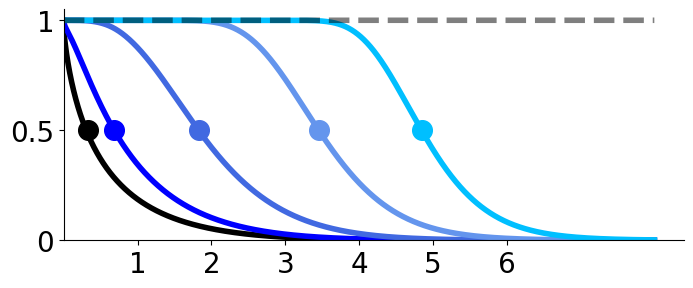

In [797]:
colors = ['blue', 'royalblue', 'cornflowerblue', 'deepskyblue', 'cyan']


fig, ax = plt.subplots(figsize=(8,3))


plt.plot(t, MI_og, color='black', linewidth=lw)
plt.scatter(t_life_og, 0.5*MI[0], color='black', s=200, zorder=3)

for N in range(0, num_N):
    params['N'] = N_list[N]#2**N
    p_z_given_0, p_z_given_1 = get_probs_ntwostate(t, params)
    #print(np.isnan(np.sum(p_z_given_1)))
    
    MI = get_MI(p_z_given_0, p_z_given_1)
    t_life = t[np.argwhere(MI <= 0.5*MI[0])[0]]
    
    
    plt.plot(t, MI, linewidth=lw, color=colors[N])
    plt.scatter(t_life, 0.5*MI[0], color=colors[N], s=200, zorder=3)


plt.plot(t, np.ones_like(t), linestyle='--', color='black', linewidth=4, alpha=0.5) 

ax.spines[['right', 'top']].set_visible(False)
plt.xticks([1, 2, 3, 4, 5, 6],fontsize=20); 
plt.yticks([0,0.5, 1], ['0','0.5', '1'], fontsize=20)
plt.xlim(0, None); plt.ylim(0, None)

save_file('MI_twostate_vs_N')
plt.show()

## k. Lifetime vs $N$ for $N$ two-state models, given different levels of marking noise

Plot lifetime vs $\log_{10} N$ for $N$ two-state models, given three different levels of marking noise ($\epsilon = 0.001, 0.01, 0.1$).

In [808]:
t_min, t_max, num_t = 1e-10, 8, 1000
t = np.linspace(t_min, t_max, num_t)

N_list = np.logspace(0., 4, 100, base=10, dtype=int)
print(N_list)
num_N = len(N_list)


params_list = []
for i in range(num_N): params_list.append( {'eps':0.001, 'gamma':gamma, 'N':N_list[i]}   )
t_life_low = get_t_life(t, params_list, get_probs_ntwostate, get_MI )

params_list = []
for i in range(num_N): params_list.append( {'eps':0.01, 'gamma':gamma, 'N':N_list[i]}   )
t_life_med = get_t_life(t, params_list, get_probs_ntwostate, get_MI )

params_list = []
for i in range(num_N): params_list.append( {'eps':0.1, 'gamma':gamma, 'N':N_list[i]}   )
t_life_hi = get_t_life(t, params_list, get_probs_ntwostate, get_MI )

[    1     1     1     1     1     1     1     1     2     2     2     2
     3     3     3     4     4     4     5     5     6     7     7     8
     9    10    11    12    13    14    16    17    19    21    23    25
    28    31    34    37    41    45    49    54    59    65    72    79
    86    95   104   114   126   138   151   166   183   200   220   242
   265   291   319   351   385   422   464   509   559   613   673   739
   811   890   977  1072  1176  1291  1417  1555  1707  1873  2056  2257
  2477  2718  2983  3274  3593  3944  4328  4750  5214  5722  6280  6892
  7564  8302  9111 10000]


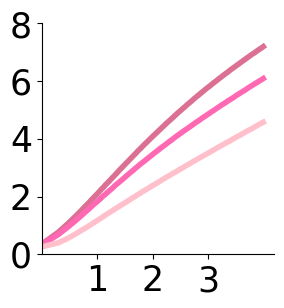

In [809]:
fig, ax = plt.subplots(figsize=(3,3))


plt.plot(np.log10(N_list), t_life_low, linewidth=lw, color=c_eps_low)
plt.plot(np.log10(N_list), t_life_med, linewidth=lw, color=c_eps_med)
plt.plot(np.log10(N_list), t_life_hi, linewidth=lw, color=c_eps_hi)

plt.xlim(0,None)
plt.ylim(0, 8)
plt.xticks([1, 2, 3],fontsize=25); 
plt.yticks([0, 2, 4, 6, 8], fontsize=25); 
ax.spines[['right', 'top']].set_visible(False)

save_file('lifetime_twostate_vs_N')
plt.show()

## l. Capacity vs marking noise for $N$ two-state models, for different values of $N$

Plot capacity vs marking noise for $N$ two-state models, for different values of $N$ ($N = 1, 2, 10$).

In [815]:
# p = p(1 | 0), false positive
gamma = 1
eps_min, eps_max, num_eps = 0, gamma, 200
epsilon = np.linspace(eps_min, eps_max, num_eps)

p_base = epsilon/(gamma + epsilon) + 1e-15

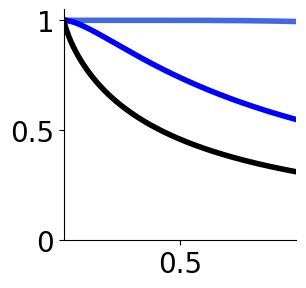

In [817]:
N_list = [1, 2, 10]
num_N = len(N_list)
colors = ['black', 'blue', 'royalblue', 'deepskyblue', 'red']


fig, ax = plt.subplots(figsize=(3,3))

for i in range(num_N):
    N = N_list[num_N - i - 1]
    
    p = p_base**N
    C = get_capacity(p)

    plt.plot(epsilon, C, color=colors[num_N-i-1], linewidth=lw)
    

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xticks([0.5],fontsize=20); 
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'],fontsize=20); 
ax.spines[['right', 'top']].set_visible(False)

save_file('capacity_Ntwostate')
plt.show()